Testing gsw python for TEOS-10 compatibility

TEOS-10 - http://www.teos-10.org/

gsw python - https://pypi.python.org/pypi/gsw

In [1]:
import gsw
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import scipy.io

from salishsea_tools import viz_tools, teos_tools

%matplotlib inline

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


# Matlab tests

In [2]:
# Load gsw Matlab demo file
f = scipy.io.loadmat('/data/nsoontie/GSW/library/gsw_data_v3_0.mat')
demo = f['gsw_demo_data']
# grab data - subsampled like in matlab demo. Why is creating a list of indices so hard?
ind_sub = np.arange(28,48,4)
ind_sub =  [i for i in ind_sub]
indices = [0,21]
for i in ind_sub:
    indices.append(i)

p = np.array([demo['p'][0][0][i,0] for i in indices])
t = np.array([demo['t'][0][0][i,0] for i in indices])
SP = np.array([demo['SP'][0][0][i,0] for i in indices])


long = demo['long'][0][0][0,0]
lat = demo['lat'][0][0][0,0]

## Practical salinity to absolute salinity

In [3]:
#copied from Matlab gsw_demo output
SA_Mat = np.array([ 34.7392,  34.4652,  34.7738,  34.8435,  34.8637,  34.8739,  34.8776,] )

In [4]:
SA_py = gsw.SA_from_SP(SP,p, long, lat)
SA_py

array([ 34.73922653,  34.46519542,  34.7738161 ,  34.84347021,
        34.86368827,  34.87389077,  34.87760285])

In [5]:
(np.abs(SA_py-SA_Mat) < 1e-4).all()

True

Yes, up to the accuracy I copied from Matalb results, the answers are the same.

## In-situ temperature to conservative temperature

In [6]:
#copied from output of gsw_demo
CT_Mat = np.array([ 19.5130,   3.5588,   1.8157,   1.3434,   1.1583,   1.0518,  1.0073, ] )

CT_py = gsw.CT_from_t(SA_py, t, p)
CT_py

array([ 19.51302027,   3.55877109,   1.81571146,   1.34340125,
         1.15831711,   1.05175362,   1.0073248 ])

In [7]:
(np.abs(CT_py - CT_Mat) < 1e-4).all()

True

Again, up to accuracy copied from matlab, the results are the same.

## Density

In [8]:
#copied from output of gsw_demo
rho_Mat = np.array([ 1024.5709,  1031.9377,  1037.0031,  1041.6695,  1046.1799,  1050.5915, 1054.9014, ] )

rho_py = gsw.rho(SA_py, CT_py, p)
rho_py

array([ 1024.57149173,  1031.93720792,  1037.00233755,  1041.6688784 ,
        1046.17966141,  1050.59166961,  1054.90183236])

In [9]:
(np.abs(rho_py-rho_Mat) < 1e-4).all()

False

In [10]:
rho_py-rho_Mat

array([ 0.00059173, -0.00049208, -0.00076245, -0.0006216 , -0.00023859,
        0.00016961,  0.00043236])

Ok, I'm starting to get some differences here. They are pretty small (< 1e-3).

# Notes

## What is conservative temperature?
From TEOS-10 primer:

$CT = \frac{h_0}{c_p^0}$

where $h_0$ is the potential enthalpy and $c_p^0$ is a scale factor that makes potential temperature and conservative temperature numerically similar for typical seawater (practical salinty =35 psu, in-situ temperature = 0 deg C). Potential enthalpy is a measure of heat content. 

The primer says that the difference between potential temperature and conservative temperature can be high (like 1 deg C) when salinity is low and temperature is high. So, I think that applies to the Strait of Georgia. 

### Model Potential temperature vs Conservative temperature

In [11]:
j=450
i=300
t=0

f = nc.Dataset('/results/SalishSea/nowcast/18jul16/SalishSea_1h_20160718_20160718_grid_T.nc')
b = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
mesh = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/mesh_mask_SalishSea2.nc')
tmask = mesh.variables['tmask'][0,:,j,i]

SP = f.variables['vosaline'][t,:,j,i]
PT = f.variables['votemper'][t,:,j,i]
d = f.variables['deptht'][:]
lon = f.variables['nav_lon'][j,i]
lat = f.variables['nav_lat'][j,i]

p = gsw.p_from_z(-d,lat)
SA = gsw.SA_from_SP(SP,p,lon, lat)
SA_ourway = teos_tools.psu_teos(SP)
CT = gsw.CT_from_pt(SA,PT)*tmask
CT_ourway = gsw.CT_from_pt(SA_ourway, PT)*tmask

In [12]:
# gsw conservative temperature
print(CT)

[ 18.54488417  17.56862521  17.42742272  17.41925829  16.58884243
  15.4779052   14.69812997  14.18634375  13.84552267  13.61449011
  13.4457867   13.31160232  13.19744722  13.09557244  13.00127885
  12.91124589  12.82249668  12.73076578  12.62849813  12.50248551
  12.33414608  12.11734454  11.84564998  11.5303982   11.20087562
  10.9018814   10.58064551  10.25672755  10.04754812  10.04379347   0.           0.
   0.           0.           0.           0.           0.           0.           0.
   0.        ]


In [13]:
# Model potential temperature
print(PT)

[ 17.77445984  16.89507294  16.90116119  17.00209045  16.2517643   15.204669
  14.47402763  13.99744987  13.68003845  13.46333981  13.30323792
  13.17446136  13.06399441  12.96485233  12.8727417   12.78457069
  12.69750786  12.60741043  12.50686836  12.38288212  12.21716499
  12.003685    11.73606777  11.4257412   11.10178757  10.80835342
  10.49211311  10.17195797   9.96551704   9.96292782   0.           0.           0.
   0.           0.           0.           0.           0.           0.           0.        ]


In [14]:
# Model potential - gsw conservative temperature
print(PT-CT)

[-0.77042433 -0.67355228 -0.52626153 -0.41716784 -0.33707814 -0.2732362
 -0.22410233 -0.18889387 -0.16548422 -0.1511503  -0.14254878 -0.13714096
 -0.13345281 -0.13072011 -0.12853715 -0.12667519 -0.12498882 -0.12335535
 -0.12162977 -0.1196034  -0.11698109 -0.11365954 -0.10958221 -0.104657
 -0.09908805 -0.09352797 -0.0885324  -0.08476958 -0.08203108 -0.08086565
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


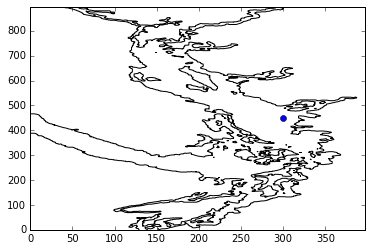

In [15]:
fig,ax = plt.subplots(1,1)
viz_tools.plot_coastline(ax,b)
ax.plot(i,j,'o')

### Some other stuff

In [16]:
#our way of calculating Absolute Salinty vs gsw Absolute Salinity
print (SA_ourway - SA)

[-0.00083381 -0.00114889 -0.00188738 -0.00241163 -0.00269488 -0.00288674
 -0.00304171 -0.00314805 -0.00320395 -0.00321582 -0.00322963 -0.00324751
 -0.00325636 -0.00326041 -0.00326227 -0.00326358 -0.00326209 -0.00326187
 -0.00325879 -0.00315175 -0.00296749 -0.00268155 -0.00254945 -0.00254204
 -0.00275194 -0.00313342 -0.00367954 -0.00419892 -0.00481103 -0.00531033
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


In [17]:
# Conservative temperature with our way Absolute Salinity vs gsw Conservative temperature
print (CT_ourway - CT)

[  2.16073156e-05   2.84274858e-05   4.75869064e-05   6.21947259e-05
   6.75235223e-05   6.88970087e-05   7.02177201e-05   7.11666551e-05
   7.14324396e-05   7.09930989e-05   7.07423701e-05   7.06570799e-05
   7.04217499e-05   7.01138148e-05   6.97792006e-05   6.94439860e-05
   6.90507563e-05   6.86698943e-05   6.81834067e-05   6.54390184e-05
   6.09762901e-05   5.43584451e-05   5.07940507e-05   4.96251891e-05
   5.25781075e-05   5.87000617e-05   6.74280449e-05   7.51658597e-05
   8.48207026e-05   9.36572757e-05   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
